# 스테이블 디퓨전 XL을 활용한 스타일 변환 실습

# 1. 스테이블 디퓨전 XL(Stable Diffusion XL; SDXL) 모델 패키지 구독하기

SDXL 모델 패키지를 구독하려면:
1. SDXL 모델 패키지 목록 페이지 열기: https://aws.amazon.com/marketplace/pp/prodview-pe7wqwehghdtm
1. AWS 마켓플레이스 목록에서 **Continue to subscribe(계속해서 구독하기)** 버튼 클릭하기
1. **이 소프트웨어 구독하기** 페이지에서 EULA, 가격 및 지원 조건을 검토하고 **"Accept Offer(제안 수락)"** 버튼 클릭하기

In [ ]:
!pip install -U 'stability-sdk[sagemaker] @ git+https://github.com/Stability-AI/stability-sdk.git@sagemaker'
! pip install protobuf==3.20


import sagemaker
from sagemaker import ModelPackage, get_execution_role
from stability_sdk_sagemaker.predictor import StabilityPredictor
from stability_sdk_sagemaker.models import get_model_package_arn
from stability_sdk.api import GenerationRequest, GenerationResponse, TextPrompt

from PIL import Image
from typing import Union, Tuple
import io
import os
import base64
import boto3

# 2. 엔드포인트 생성 및 실시간 추론 수행

In [4]:
# # 엔드포인트 이름 선택하기
# from sagemaker.utils import name_from_base
# endpoint_name=name_from_base('sdxl-1-0-jumpstart') # 엔드포인트를 원하는 이름으로 변경하세요.

In [3]:
endpoint_name="sdxl-1-0-intro-2023-09-10-18-23-56-477"

Stability SDXL 모델 구독 후, 아래 맵 객체를 사용해 모델 패키지 ARN 가져오세요:


In [4]:
model_package_map = {
    "us-east-1": "arn:aws:sagemaker:us-east-1:865070037744:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-east-2": "arn:aws:sagemaker:us-east-2:057799348421:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-west-2": "arn:aws:sagemaker:us-west-2:594846645681:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ca-central-1": "arn:aws:sagemaker:ca-central-1:470592106596:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-central-1": "arn:aws:sagemaker:eu-central-1:446921602837:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-1": "arn:aws:sagemaker:eu-west-1:985815980388:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-2": "arn:aws:sagemaker:eu-west-2:856760150666:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-2": "arn:aws:sagemaker:ap-northeast-2:745090734665:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-1": "arn:aws:sagemaker:ap-northeast-1:977537786026:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-south-1": "arn:aws:sagemaker:ap-south-1:077584701553:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad"
}


region = boto3.Session().region_name
if region not in model_package_map.keys():
    raise ("UNSUPPORTED REGION")
package_arn = model_package_map[region]  # TODO

role_arn = get_execution_role()
sagemaker_session = sagemaker.Session()

배포가능한 `ModelPackage` 생성하세요. SDXL 1.0는 다음 인스턴스 유형 중 하나를 아래 `instance_type`에 지정하세요: ml.g5.2xlarge, ml.p4d.24xlarge, p4de.24xlarge.


In [5]:
# model = ModelPackage(role=role_arn,model_package_arn=package_arn,sagemaker_session=sagemaker_session,predictor_cls=StabilityPredictor)


# # 모델 패키지를 배포하세요. 이 작업은 5~10분 정도 소요됩니다.

# instance_type="ml.g5.2xlarge" # valid instance types for this model are ml.g5.2xlarge, p4d.24xlarge, and p4de.24xlarge
# deployed_model = model.deploy(initial_instance_count=1,instance_type=instance_type,endpoint_name=endpoint_name)


모델을 이미 배포한 경우, 선택한 `endpoint_name`과 `sagemaker_session`을 통해 접근할 수 있습니다.


In [6]:
deployed_model = StabilityPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)

배포된 모델에서 `predict`를 호출해 모델 출력을 반환할 수 있습니다. 전체 매개변수 목록을 보려면 [Stability.ai SDK 문서를 확인하세요.](https://api.stability.ai/docs#tag/v1generation)

## A. 텍스트-이미지 변환


In [28]:
prompt="Create an image of a dog dressed as a ninja eating ice cream"

In [29]:
image_path = "generated-images"

In [30]:
image_name = "{}.png".format(prompt.replace(" ", "_"))
image_name

'Create_an_image_of_a_dog_dressed_as_a_ninja_eating_ice_cream.png'

In [31]:
output = deployed_model.predict(
    GenerationRequest(
        text_prompts=[TextPrompt(text=prompt)],
        style_preset="anime",
        width=1024,
        height=1024,
        seed=5,
    )
)

응답의 `artifacts`에는 base64로 인코딩된 문자열 형태로 출력 이미지가 포함됩니다. 아래는 이러한 이미지를 디코딩하는 데 도움이 되는 헬퍼 함수입니다.

In [32]:
def decode_and_show(model_response: GenerationResponse) -> None:
    """
    SDXL 출력에서 이미지 디코딩하고 표시하기

    매개변수:
        model_response (GenerationResponse): 배포된 SDXL 모델의 응답 객체.

    응답:
        없음
    """
    image = model_response.artifacts[0].base64
    image_data = base64.b64decode(image.encode())
    image = Image.open(io.BytesIO(image_data))
    image.save(image_path+"/"+image_name)
    display(image)

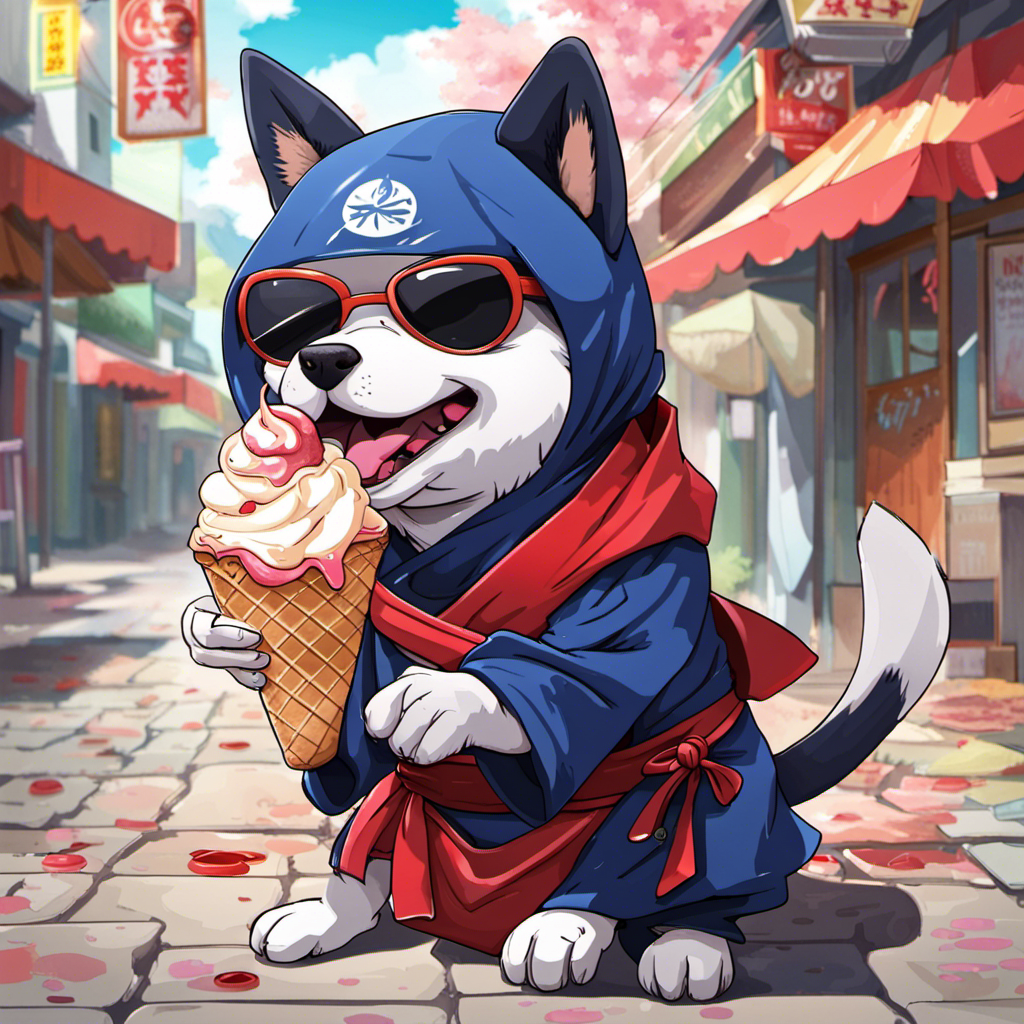

In [33]:
decode_and_show(output)

## B. 이미지-이미지 변환

추론을 수행할 때 입력으로 이미지를 사용하려면 이미지를 base64로 인코딩된 문자열 형태로 매개변수 `init_image`로 전달해야 합니다. 출력 이미지와 마찬가지로 입력 이미지는 지원되는 해상도 중 하나여야 합니다 (높이, 너비) 조합으로 (1024, 1024), (1152, 896), (896, 1152), (1216, 832), (832, 1216), (1344, 768), (768, 1344), (1536, 640), (640, 1536) 중 하나여야 합니다.

아래는 이미지를 base64로 인코딩된 문자열로 변환하는 헬퍼 함수입니다.

In [34]:
def encode_image(image_path: str, resize: bool = False, size: Tuple[int, int] = (1024, 1024)) -> Union[str, None]:
    """
    이미지를 base64 문자열로 인코딩하고, 선택적으로 지원되는 해상도로 크기를 조정합니다..

    매개변수:
        image_path (str): 이미지 파일의 경로.
        resize (bool, optional): 이미지를 크기 조정할지 여부. 기본값은 True.

    응답:
        Union[str, None]: 문자열로 인코딩된 이미지 또는 인코딩에 실패한 경우 None.
    """
    assert os.path.exists(image_path)
    image = Image.open(image_path)

    if resize:
        image = Image.open(image_path)
        image = image.resize(size)
        updated_image_path = "resize-{}".format(image_path)       
        image.save(updated_image_path)
        image_path = updated_image_path

    assert image.size == size
    with open(image_path, "rb") as image_file:
        img_byte_array = image_file.read()
        # 바이트 배열을 Base64 문자열로 인코딩
        try:
            base64_str = base64.b64encode(img_byte_array).decode("utf-8")
            return base64_str
        except Exception as e:
            print(f"Failed to encode image {image_path} as base64 string.")
            print(e)
            return None

이번에는 이미지를 모델에 프롬프트와 함께 입력해 보겠습니다. `image_scale`을 설정해 이미지와 프롬프트의 상대적인 중요도를 조정할 수 있습니다.

# 스타일 변환 예시

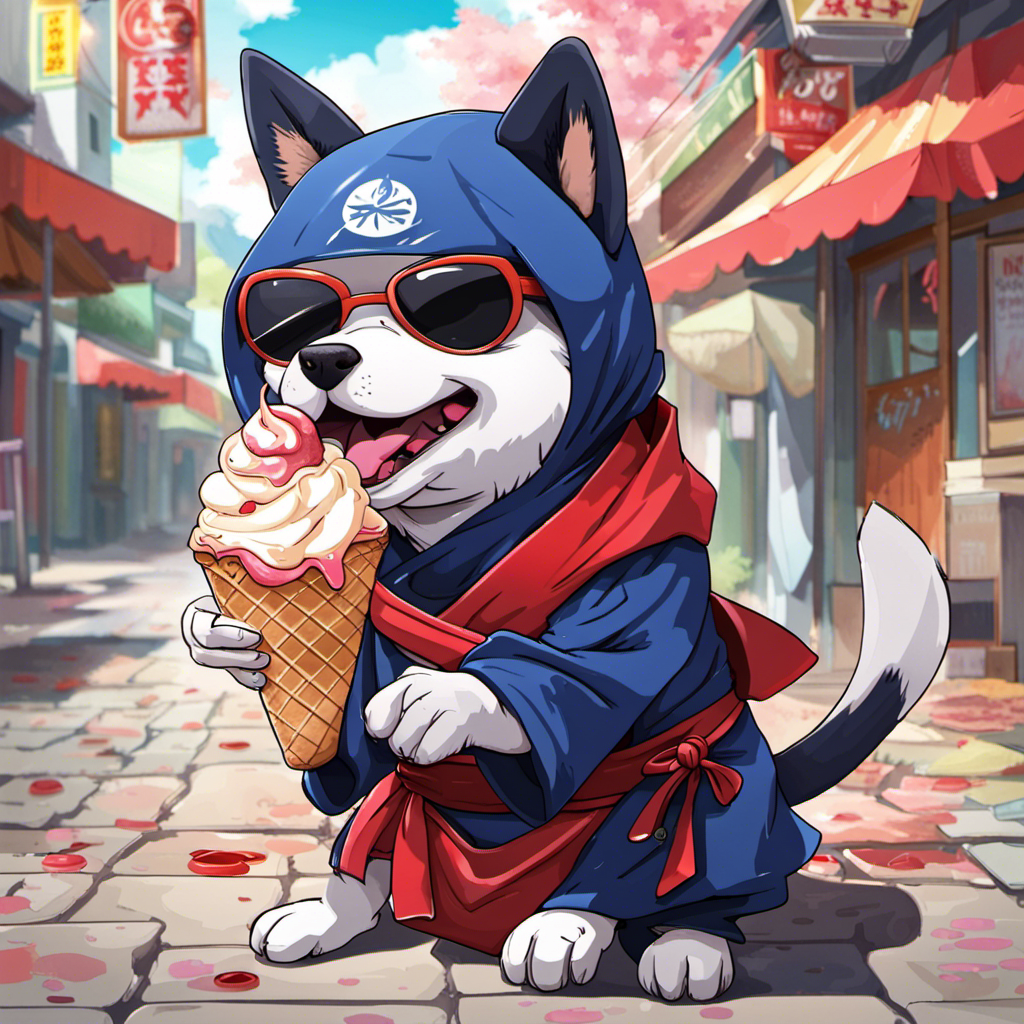

In [35]:
# 원본 이미지 경로 지정:
display(Image.open(image_path+"/"+image_name))

In [36]:
size = (1024,1024)
image_data = encode_image(image_path+"/"+image_name, size=size)

In [37]:
new_prompt="Create a photograph of a dog dressed as a ninja eating ice cream"

In [38]:
image_name = "{}.png".format(new_prompt.replace(" ", "_"))
image_name

'Create_a_photograph_of_a_dog_dressed_as_a_ninja_eating_ice_cream.png'

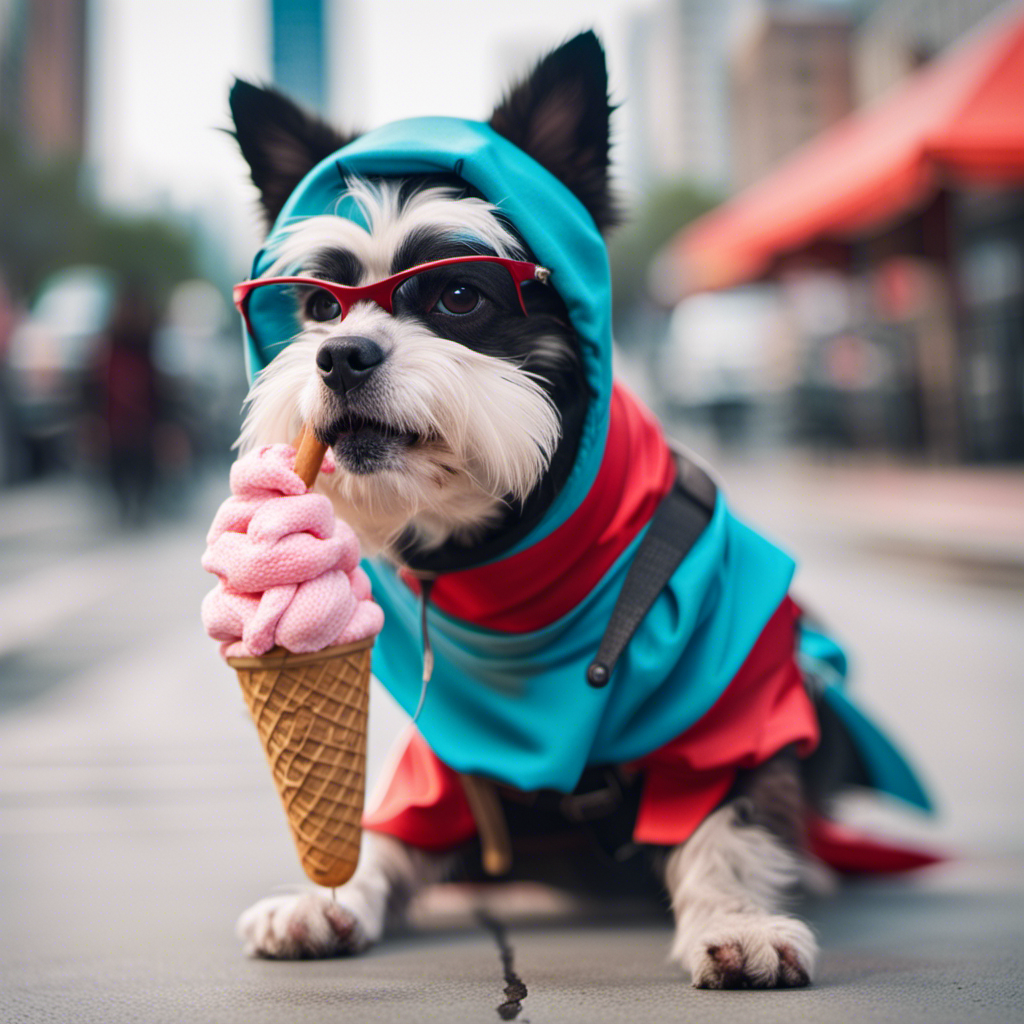

In [39]:
output = deployed_model.predict(
    GenerationRequest(
        text_prompts=[TextPrompt(text=new_prompt)],
        init_image= image_data,
        style_preset="photographic",
        cfg_scale=7,
        image_strength=0.1,
        seed=42,
        height=size[0],
        width=size[1],
        init_image_mode="IMAGE_STRENGTH"
    )
)
decode_and_show(output)

# 3. 엔드포인트 삭제

작업을 마친 후에는 엔드포인트를 삭제해 연결된 EC2 인스턴스를 해제하고 요금 부과를 중지할 수 있습니다.

AWS Sagemaker CLI를 사용해 Sagemaker 엔드포인트 목록을 확인하려면 아래 명령어를 사용하세요:

In [ ]:
!aws sagemaker list-endpoints

# 엔드포인트 삭제하기

In [ ]:
# deployed_model.sagemaker_session.delete_endpoint(endpoint_name)
# # 위의 aws cli 명령을 다시 실행해 삭제됐는지 확인하세요.